
# Productividad de pozos

Analisis estadístico y simulación de gasto en pozos. 

Información de producción histórica de hidrocarburos de la CNH.

In [5]:
from __future__ import division

import warnings

from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import calendar

In [6]:
warnings.filterwarnings("ignore")

In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.stats
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

import timeit

In [164]:
pd.set_option('display.max_rows', 100_000_000)
pd.set_option('display.max_columns', 100_000_000)
pd.set_option('display.width', 1_000)
pd.set_option('precision', 2)
pd.options.display.float_format = '{:,.2f}'.format

# Función Productividad de pozos

In [177]:
def productividad():
     
    global intervalo
    global unique_well_list
    global data_pozos
    global resultados
    global gasto_aceite
    
    tic=timeit.default_timer()
    
    
#############      ESTADISTICA DE POZOS   ####### 
    
    
    #Carga de datos   
    def campo_analisis():
        
        global campo
        global input_campo
        mx_stats=pd.read_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/mexico/mx_bd.csv',
                         low_memory=False)
    
        #Input de campo
        input_campo = input("Nombre de campo: ")
        intervalos = 3

        seleccion=mx_stats.pozo.str.contains(str(input_campo))
        campo=mx_stats.loc[seleccion]

        unique_well_list=pd.unique(campo['pozo'])

        display('Número de pozos en ' +str(input_campo)+': '+str(len(unique_well_list)))
           
        #Estadistica descriptiva
        display('Percentiles y estadistica descriptiva: ')
        display(campo.aceite_Mbd.quantile([.1,.5,.9]),
                campo.describe())  
        
        #Analisis de dispersion
        fig, ax = plt.subplots(figsize=(10,5))
        ax.scatter(campo.profundidad_vertical,campo.aceite_Mbd)
        ax.set_xlabel('Profundidad vertical')
        ax.set_ylabel('Gasto de aceite Mbd')
        plt.show()

        #Generacion de archivo de resultados
        campo.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/'+str(input_campo)+str('.csv'))

        return campo
    

########      ANALISIS DE DECLINACION DE POZOS      ####### 
    
    def remove_nan_and_zeroes_from_columns(df, variable):
        """
        This function cleans up a dataframe by removing rows in a specific 
        column that are null/NaN or equal to 0. This basically removes zero 
        production time periods.
        Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
        Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
        """
        filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
        return filtered_df

    def generate_time_delta_column(df, time_column, date_first_online_column):
        """
        Create column for the time that a well has been online at each reading, with 
        the first non-null month in the series listed as the start of production
        Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
        Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
        """
        df['days_online']=(df[time_column]-df[date_first_online_column]).dt.days
        return (df[time_column]-df[date_first_online_column]).dt.days

    def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
        global value
        """
        This function obtains the min or max value for a column, with a group by applied. For example,
        it could return the earliest (min) RecordDate for each API number in a dataframe 
        Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
        Outputs:
        value: Depends on the calc_column type.
        """
        value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
        return value

    def get_max_initial_production(df, number_first_months, variable_column, date_column):
        global df_beginning_production
        """
        This function allows you to look at the first X months of production, and selects 
        the highest production month as max initial production
        Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
        """
        #First, sort the data frame from earliest to most recent prod date
        df=df.sort_values(by=date_column)
        #Pull out the first x months of production, where number_first_months is x
        df_beginning_production=df.head(number_first_months)
        #Return the max value in the selected variable column from the newly created 
        #df_beginning_production df
        return df_beginning_production[variable_column].max()

    def hyperbolic_equation(t, qi, b, di):
        """
        Hyperbolic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/((1.0+b*di*t)**(1.0/b))

    def exponential_equation(t, qi, di):
        """
        Exponential decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi*np.exp(-di*t)

    def harmonic_equation (t, qi, di):
        """
        Harmonic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/(1+(di*t))

    def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
        """
        This function is used to map x- and y-variables against each other
        Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
        """
        #Plot resultados
        df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5),scalex=True, scaley=True)
        plt.show()
    
    resultados=pd.DataFrame()
    gasto_aceite=pd.DataFrame()
    Qi=pd.DataFrame()
    
    #Entrada de campo de análisis
    campo_analisis()
    data_pozos=campo
    #Limpieza de datos y formato de fecha
    data_pozos['fecha']=pd.to_datetime(data_pozos['fecha'])
    #Hidrocarburo de análisis
    hydrocarbon='aceite_Mbd'
    #Remove all rows with null values in the desired time series column
    data_pozos=remove_nan_and_zeroes_from_columns(data_pozos, hydrocarbon)
    #Get a list of unique wells to loop through
    unique_well_list=pd.unique(list(data_pozos.pozo))
    #Get the earliest RecordDate for each Well
    data_pozos['first_oil']= get_min_or_max_value_in_column_by_group(data_pozos, group_by_column='pozo', 
                                                                    calc_column='fecha', calc_type='min')
    #Generate column for time online delta
    data_pozos['days_online']=generate_time_delta_column(data_pozos, time_column='fecha', 
                  date_first_online_column='first_oil')
    #Pull data that came online between an specified range
    data_pozos_range=data_pozos[(data_pozos.fecha>='1900-01-01') & (data_pozos.fecha<='2019-12-01')]
    
    #Loop para realizar el DCA en cada pozo del campo
    for pozo in unique_well_list:
        #Subset el data frame del campo por pozo
        serie_produccion=data_pozos_range[data_pozos_range.pozo==pozo]
        
        #Cálculo de la máxima producción inicial
        qi=get_max_initial_production(serie_produccion, 24, hydrocarbon, 'fecha')

        #Ajuste Hiperbolico
        popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, serie_produccion['days_online'], 
                                     serie_produccion[hydrocarbon],bounds=(0, [qi,2,10]))
        #print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
        #Ajuste Harmonico
        popt_harm, pcov_harm=curve_fit(harmonic_equation, serie_produccion['days_online'], 
                                     serie_produccion[hydrocarbon],bounds=(0, [qi,10]))
        #print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', di='+str(popt_harm[1]))

        #Resultados de funcion Hiperbolica
        serie_produccion.loc[:,'hiperbolica']=hyperbolic_equation(serie_produccion['days_online'], 
                                  *popt_hyp)
        #Resultados de funcion Harmonica
        serie_produccion.loc[:,'harmonica']=harmonic_equation(serie_produccion['days_online'], 
                                  *popt_harm)
        
        #Error
        perr = np.sqrt(np.diag(pcov_harm))

        serie_produccion.loc[:,'Qi_harmonic']=popt_harm[0]
        serie_produccion.loc[:,'di_harmonic']=popt_harm[1]
        serie_produccion.loc[:,'Error Qo_harmonic']=perr[0]
        serie_produccion.loc[:,'Error di_harmonic']=perr[1]
        serie_produccion.loc[:,'mes']=(serie_produccion['aceite_Mbd'] > 0).cumsum()
        
        Qi=[[pozo,qi]]

        #Declare the x- and y- variables that we want to plot against each other
        #y_variables=[hydrocarbon,'Hyperbolic_Predicted','Exponential_Predicted','Harmonic_Predicted']
        #x_variable='month'
        #Create the plot title
        #plot_title=hydrocarbon+' for '+str(pozo)
        #Plot the data to visualize the equation fit
        #plot_actual_vs_predicted_by_equations(serie_produccion, x_variable, y_variables, plot_title)

        resultados=resultados.append(serie_produccion,sort=True)
        gasto_aceite=gasto_aceite.append(Qi,sort=True)
        
    resultados.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')

    gasto_aceite=gasto_aceite.rename(columns={0:'Pozo',1:'Qi'})
    gasto_aceite.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/gasto.csv')
    
    #####################  PRONOSTICO Qo y RESULTADOS DCA   #####################
    
    periodo=np.arange(start=1,stop=501,step=1)
    fechas=pd.date_range(start='01-Jan-2020',freq='M',periods=500,normalize=True,closed='left')

    df=pd.DataFrame()

    df['fecha']=fechas
    df['mes']=pd.DatetimeIndex(fechas).month
    df['ano']=pd.DatetimeIndex(fechas).year
    df['dias']=pd.DatetimeIndex(fechas).day
    df['periodo']=periodo
    
    display(gasto_aceite.describe())
    
    q10=gasto_aceite.Qi.quantile(.1)
    q50=gasto_aceite.Qi.quantile(.5)
    q90=gasto_aceite.Qi.quantile(.9)

    for x in df:
        p10=(q10/((1.0+1*0.05*df.periodo)**(1.0/1)))
        p50=(q50/((1.0+1*0.05*df.periodo)**(1.0/1)))
        p90=(q90/((1.0+1*0.05*df.periodo)**(1.0/1)))
    
    fig1, ax1 = plt.subplots(figsize=(10,5))
    plt.hist(gasto_aceite.Qi, alpha=0.5, label='Gasto inicial',bins=10)
    plt.title('Histograma del gasto inicial del campo ' +str(input_campo))
    plt.legend(loc='upper right')
    
    fig2, ax2 = plt.subplots(figsize=(10,5))
    plt.hist(resultados.aceite_Mbd, alpha=0.5, label='Qo historico',bins=50)
    plt.hist(resultados.hiperbolica, alpha=0.5, label='Hyperbolic Predicted',bins=50)
    plt.title('Histograma del gasto historico vs pronosticado ' +str(input_campo))
    plt.legend(loc='upper right')
    
    #resultados=resultados.groupby(by='pozo')
    fig3, ax3 = plt.subplots(figsize=(10,5))
    ax3.scatter(resultados.mes,resultados.aceite_Mbd,cmap='viridis')
    plt.title('Tiempo vs Gasto de ' +str(hydrocarbon))
    ax3.set_xlabel('Mes')
    ax3.set_ylabel('Qo')
    plt.show()

    fig4, ax4 = plt.subplots(figsize=(10,5))    
    p10.plot(label='P10')
    p50.plot(label='P50')
    p90.plot(label='P90')
    ax4.set_xlabel('Mes')
    ax4.set_ylabel('Qo')
    plt.title('Qo - Pronostico de produccion para campo ' +str(input_campo))
    plt.legend(loc='upper right')

    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')

Nombre de campo: AYATSIL


'Número de pozos en AYATSIL: 22'

'Percentiles y estadistica descriptiva: '

0.10   2.69
0.50   4.67
0.90   5.83
Name: aceite_Mbd, dtype: float64

,Unnamed: 0,aceite_Mbd,agua_Mbd,condensado_Mbd,gas_asociado_MMpcd,gas_no_asociado_MMpcd,ano_perforacion,GID,profundidad_total,profundidad_vertical
count,461.00,461.00,461.00,461.00,461.00,461.00,463.00,463.00,417.00,136.00
mean,"685,652.85",4.47,0.04,0.00,0.50,0.00,"2,014.91","35,322,720.47","4,394.24","4,122.44"
std,"21,749.22",1.30,0.07,0.00,0.15,0.00,3.60,"57,920,664.21",363.92,414.10
min,"616,685.00",0.23,0.00,0.00,0.03,0.00,"2,007.00","237,741.00","3,873.50","3,676.30"
25%,"671,682.00",4.02,0.00,0.00,0.45,0.00,"2,015.00","246,098.00","4,077.00","3,676.30"
50%,"691,018.00",4.67,0.01,0.00,0.52,0.00,"2,016.00","247,878.00","4,350.00","3,953.70"
75%,"703,609.00",5.32,0.03,0.00,0.60,0.00,"2,017.00","97,455,748.00","4,800.00","4,709.00"
max,"713,205.00",6.85,0.63,0.00,0.77,0.00,"2,019.00","227,094,974.00","4,958.00","4,709.00"


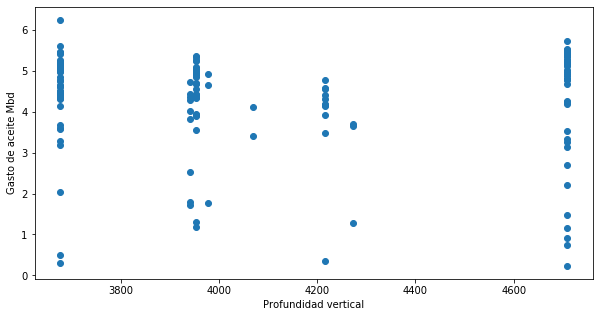

,Qi
count,20.00
mean,5.63
std,0.84
min,3.71
25%,5.17
50%,5.82
75%,6.26
max,6.85


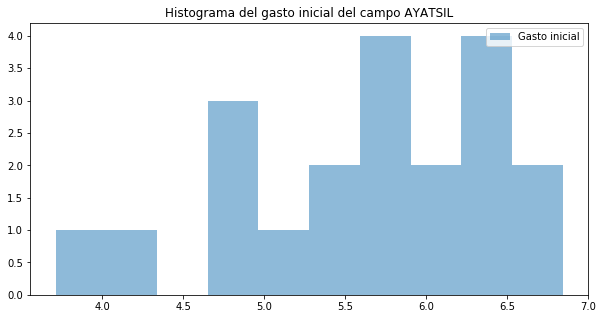

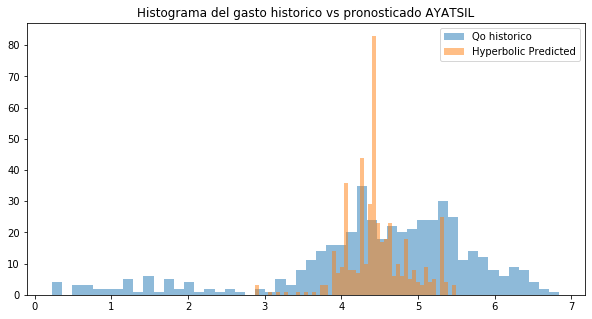

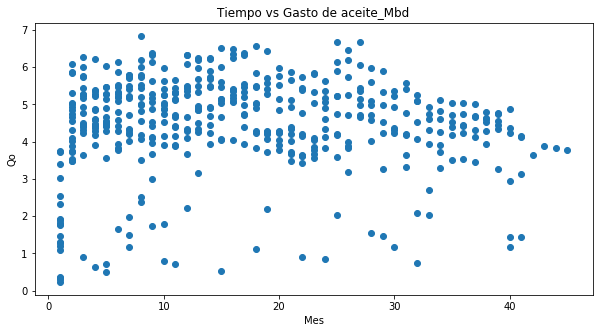

'Tiempo de procesamiento: 19.691506088000096 segundos'

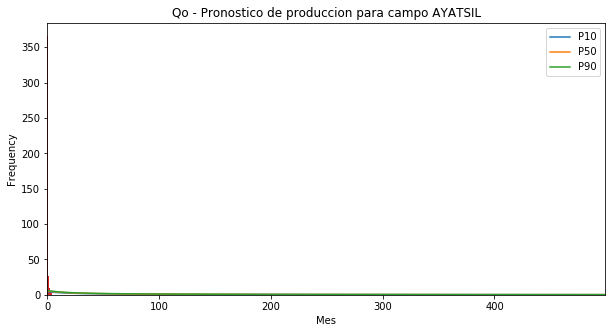

In [174]:
productividad()

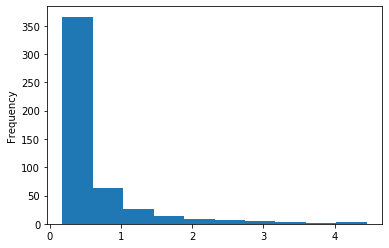

In [178]:
p10.plot.hist()

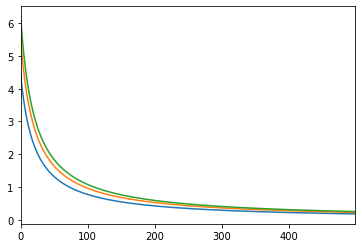

In [176]:
q10=gasto_aceite.Qi.quantile(.1)
q50=gasto_aceite.Qi.quantile(.5)
q90=gasto_aceite.Qi.quantile(.9)

for x in df:
    p10=(q10/((1.0+1*0.05*df.periodo)**(1.0/1)))
    p50=(q50/((1.0+1*0.05*df.periodo)**(1.0/1)))
    p90=(q90/((1.0+1*0.05*df.periodo)**(1.0/1)))
    
    gasto=pd.DataFrame([[x,p10,p50,p90]])
    
p10.plot()
p50.plot()
p90.plot()

In [90]:
oil=results[['pozo','aceite_Mbd','month']]

df2=oil.groupby('month').mean().reset_index()

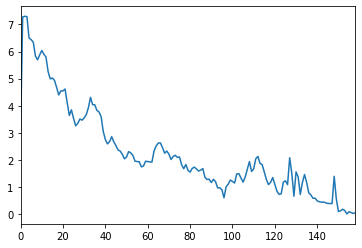

In [91]:
df2.aceite_Mbd.plot()

NameError: name 'mx_stats' is not defined

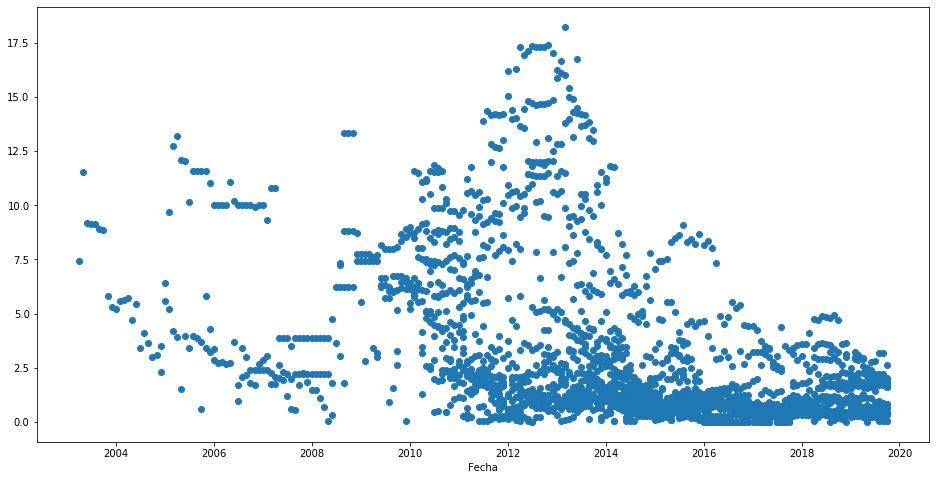

In [95]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(campo.fecha,campo.aceite_Mbd)
ax.set_xlabel('Fecha')
ax.set_xticklabels(labels=mx_stats.pozo,rotation=90)
ax.set_ylabel('Gasto de aceite Mbd')
plt.show()